# 8-Interpretation

# OBJ 1 - Random Forest Classifier model 

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline

# Create a Spark session
spark = SparkSession.builder.appName("RandomForestClassifierModel").getOrCreate()

# Load data
csv_file_path = 'Merged-data.csv'
df = spark.read.format("csv").option("header", "true").load(csv_file_path)

# Using Binary target variable (1 or 0)
# If 'ClientsSeenRate' > threshold, set 'Target' to 1; otherwise, set it to 0.
threshold = 200
df = df.withColumn('Target', (df['ClientsSeenRate'] > threshold).cast("integer"))

# Select the features and target variable
selected_cols = ['Gender', 'AgeGroup', 'Ethnicity']
feature_cols = ['encoded_' + col for col in selected_cols]

# Encode categorical variables (Gender, AgeGroup, Ethnicity)
indexers = [StringIndexer(inputCol=col, outputCol='encoded_' + col, handleInvalid='keep', stringOrderType="frequencyDesc").fit(df) for col in selected_cols]
pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

# Split the data into training and testing sets
(train_data, test_data) = df.randomSplit([0.7, 0.3], seed=42)

# Create a Random Forest classifier with a seed
rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="Target", seed=42)

# Create a parameter grid for cross-validation
param_grid = ParamGridBuilder() \
    .addGrid(rf_classifier.numTrees, [10, 20, 30]) \
    .addGrid(rf_classifier.maxDepth, [5, 10, 15]) \
    .build()

# Set up the cross-validator
evaluator = MulticlassClassificationEvaluator(labelCol="Target", predictionCol="prediction", metricName="accuracy")
cross_validator = CrossValidator(estimator=rf_classifier,
                                 estimatorParamMaps=param_grid,
                                 evaluator=evaluator,
                                 numFolds=4,  # We can adjust the number of folds as needed
                                 seed=42)

# Run cross-validation and choose the best set of parameters
cv_model = cross_validator.fit(train_data)

# Make predictions on the test set using the best model
cv_predictions = cv_model.transform(test_data)

# Fit the Random Forest model on the entire training set
final_model = rf_classifier.fit(train_data)

# Calculate accuracy
accuracy = evaluator.evaluate(cv_predictions)
print("Accuracy:", accuracy)


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/10 08:54:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/10 08:54:33 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Accuracy: 0.8138921657067518


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/11 19:42:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/11 19:42:33 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


encoded_Ethnicity: 0.755
encoded_Gender: 0.219
encoded_AgeGroup: 0.027


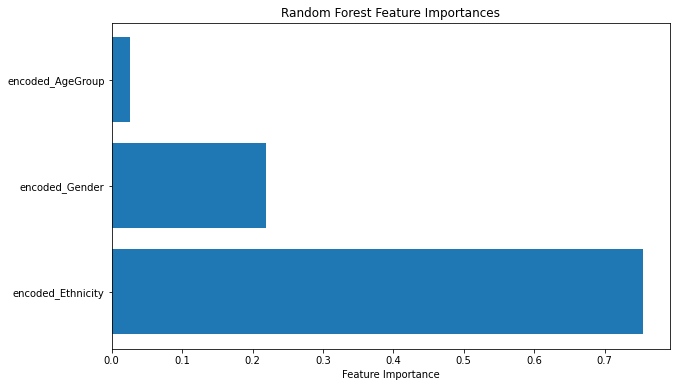

In [1]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# Create a Spark session
spark = SparkSession.builder.appName("RandomForestClassifierModel").getOrCreate()

# Load data
csv_file_path = 'Merged-data.csv'
df = spark.read.format("csv").option("header", "true").load(csv_file_path)

# Using Binary target variable (1 or 0)
# If 'ClientsSeenRate' > threshold, set 'Target' to 1; otherwise, set it to 0.
threshold = 200
df = df.withColumn('Target', (df['ClientsSeenRate'] > threshold).cast("integer"))

# Select the features and target variable
selected_cols = ['Gender', 'AgeGroup', 'Ethnicity']
feature_cols = ['encoded_' + col for col in selected_cols]

# Encode categorical variables (Gender, AgeGroup, Ethnicity)
indexers = [StringIndexer(inputCol=col, outputCol='encoded_' + col, handleInvalid='keep', stringOrderType="frequencyDesc").fit(df) for col in selected_cols]
pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

# Split the data into training and testing sets
(train_data, test_data) = df.randomSplit([0.7, 0.3], seed=42)

# Create a Random Forest classifier with a seed
rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="Target", seed=42)

# Fit the Random Forest model on the entire training set
final_model = rf_classifier.fit(train_data)

# Get feature importances and sort them
feature_importances = final_model.featureImportances.toArray()
sorted_feature_importances = sorted(zip(feature_cols, feature_importances), key=lambda x: x[1], reverse=True)

# Print sorted feature importances with three decimal places
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance:.3f}")

# Plot sorted feature importances
plt.figure(figsize=(10, 6))
plt.barh([feature for feature, _ in sorted_feature_importances], [importance for _, importance in sorted_feature_importances])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.show()


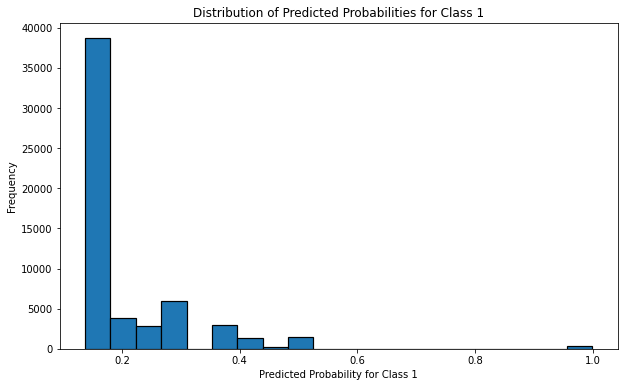

In [13]:
# Make predictions on the test set
predictions = final_model.transform(test_data)

# Extract predicted probabilities for class 1 (positive class)
predicted_probabilities = [float(row.probability[1]) for row in predictions.select('probability').collect()]

# Create a plot for predicted probabilities
plt.figure(figsize=(10, 6))
plt.hist(predicted_probabilities, bins=20, edgecolor='black', linewidth=1.2)
plt.xlabel('Predicted Probability for Class 1')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities for Class 1')
plt.show()


In [15]:
import pandas as pd

# Create a DataFrame with predicted probabilities
predictions_df = pd.DataFrame({'Predicted_Probabilities': predicted_probabilities})

# Display the summary statistics of predicted probabilities
summary_statistics = predictions_df.describe()

# Display the table
print("Summary Statistics of Predicted Probabilities:")
print(summary_statistics)


Summary Statistics of Predicted Probabilities:
       Predicted_Probabilities
count             57644.000000
mean                  0.198066
std                   0.115909
min                   0.137236
25%                   0.137236
50%                   0.137236
75%                   0.227371
max                   0.999402


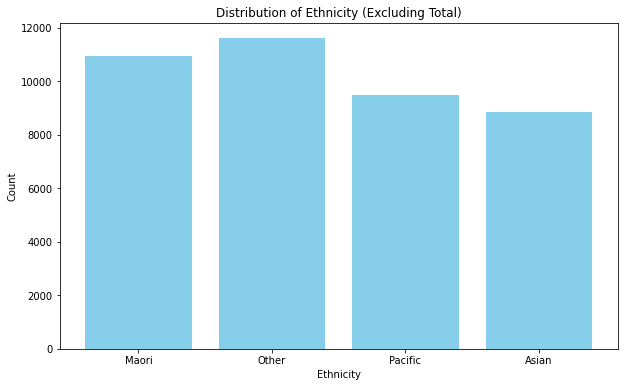

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

#'df' is the Spark DataFrame
ethnicity_counts = df.filter(df['Ethnicity'] != 'Total').groupBy('Ethnicity').count().toPandas()

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.bar(ethnicity_counts['Ethnicity'], ethnicity_counts['count'], color='skyblue')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.title('Distribution of Ethnicity (Excluding Total)')
plt.show()


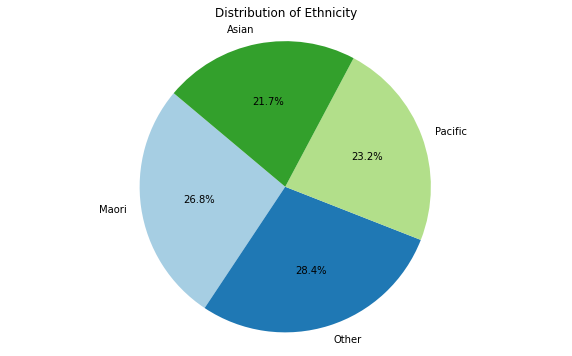

Ethnicity Distribution Table:
  Ethnicity  count
0     Maori  10945
1     Other  11604
2   Pacific   9473
3     Asian   8855


In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# 'df' is the Spark DataFrame
ethnicity_counts = df.filter(df['Ethnicity'] != 'Total').groupBy('Ethnicity').count().toPandas()

# Plotting the pie chart
plt.figure(figsize=(10, 6))
plt.pie(ethnicity_counts['count'], labels=ethnicity_counts['Ethnicity'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Ethnicity')
plt.show()

# Display the table for the pie chart
print("Ethnicity Distribution Table:")
print(ethnicity_counts)


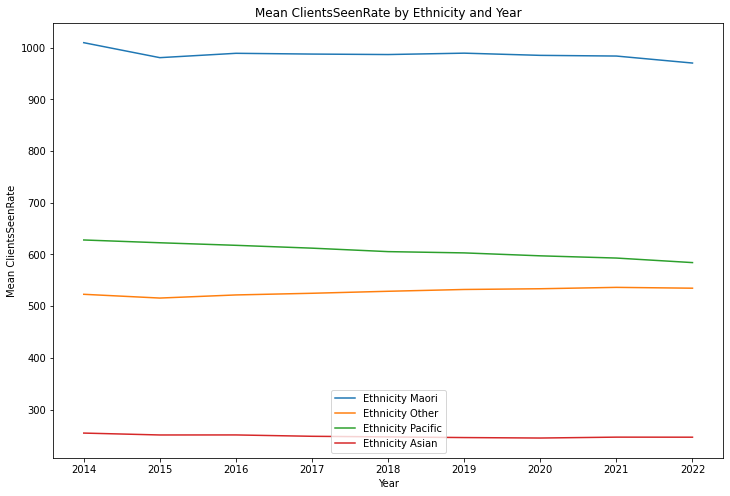

In [12]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.window import Window
from pyspark.sql import functions as F

#'df' is the Spark DataFrame
spark = SparkSession.builder.appName("LineGraphEthnicityYear").getOrCreate()

# Filter out rows with 'Total' Ethnicity
df_filtered = df.filter(col('Ethnicity') != 'Total')

# Calculate the mean of ClientsSeenRate for each Ethnicity and Year
mean_clients_seen_rate = df_filtered.groupBy('Ethnicity', 'Year') \
    .agg(F.mean('ClientsSeenRate').alias('MeanClientsSeenRate'))

# Sort by Year
windowSpec = Window.partitionBy('Ethnicity').orderBy('Year')
mean_clients_seen_rate = mean_clients_seen_rate.withColumn('MeanClientsSeenRate', F.mean('MeanClientsSeenRate').over(windowSpec))

# Get unique values of Ethnicity
unique_ethnicities = mean_clients_seen_rate.select('Ethnicity').distinct().rdd.flatMap(lambda x: x).collect()

# Plotting the graph
plt.figure(figsize=(12, 8))

# Iterate over unique ethnicities
for ethnicity in unique_ethnicities:
    data_subset = mean_clients_seen_rate.filter(col('Ethnicity') == ethnicity).orderBy('Year').collect()
    years = [row['Year'] for row in data_subset]
    mean_clients_seen_rates = [row['MeanClientsSeenRate'] for row in data_subset]
    plt.plot(years, mean_clients_seen_rates, label=f'Ethnicity {ethnicity}')

plt.xlabel('Year')
plt.ylabel('Mean ClientsSeenRate')
plt.title('Mean ClientsSeenRate by Ethnicity and Year')
plt.legend()
plt.show()




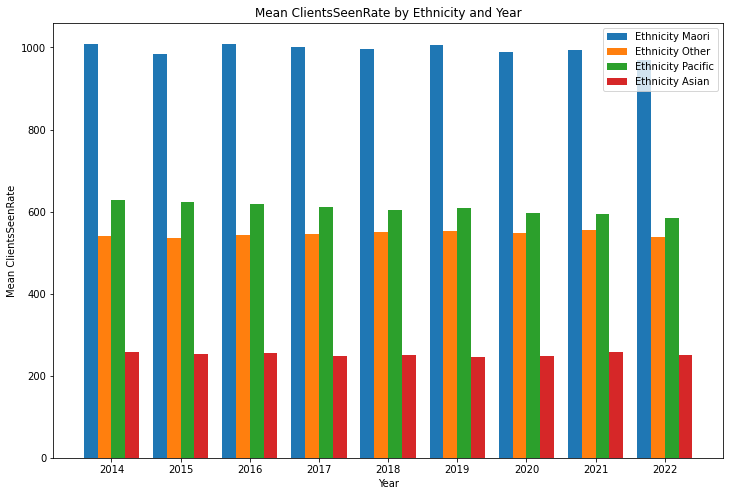

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# 'df' is the Spark DataFrame
spark = SparkSession.builder.appName("GroupedBarChartEthnicityYear").getOrCreate()

# Filter out rows with 'Total' Ethnicity
df_filtered = df.filter(col('Ethnicity') != 'Total')

# Calculate the mean of ClientsSeenRate for each Ethnicity and Year
mean_clients_seen_rate = df_filtered.groupBy('Ethnicity', 'Year') \
    .agg(F.mean('ClientsSeenRate').alias('MeanClientsSeenRate'))

# Sort by the mean ClientsSeenRate in descending order
windowSpec = Window.partitionBy('Ethnicity').orderBy(F.desc('MeanClientsSeenRate'))
mean_clients_seen_rate = mean_clients_seen_rate.withColumn('MeanClientsSeenRate', F.mean('MeanClientsSeenRate').over(windowSpec))

# Get unique values of Ethnicity
unique_ethnicities = mean_clients_seen_rate.select('Ethnicity').distinct().rdd.flatMap(lambda x: x).collect()

# Plotting the grouped bar chart
plt.figure(figsize=(12, 8))

bar_width = 0.2
index = np.arange(len(mean_clients_seen_rate.select('Year').distinct().orderBy('Year').rdd.flatMap(lambda x: x).collect()))

# Iterate over unique ethnicities
for i, ethnicity in enumerate(unique_ethnicities):
    data_subset = mean_clients_seen_rate.filter(col('Ethnicity') == ethnicity).orderBy('Year').collect()
    years = [row['Year'] for row in data_subset]
    mean_clients_seen_rates = [row['MeanClientsSeenRate'] for row in data_subset]
    plt.bar(index + i * bar_width, mean_clients_seen_rates, width=bar_width, label=f'Ethnicity {ethnicity}')

plt.xlabel('Year')
plt.ylabel('Mean ClientsSeenRate')
plt.title('Mean ClientsSeenRate by Ethnicity and Year')
plt.xticks(index + bar_width * (len(unique_ethnicities) - 1) / 2, mean_clients_seen_rate.select('Year').distinct().orderBy('Year').rdd.flatMap(lambda x: x).collect())
plt.legend()
plt.show()



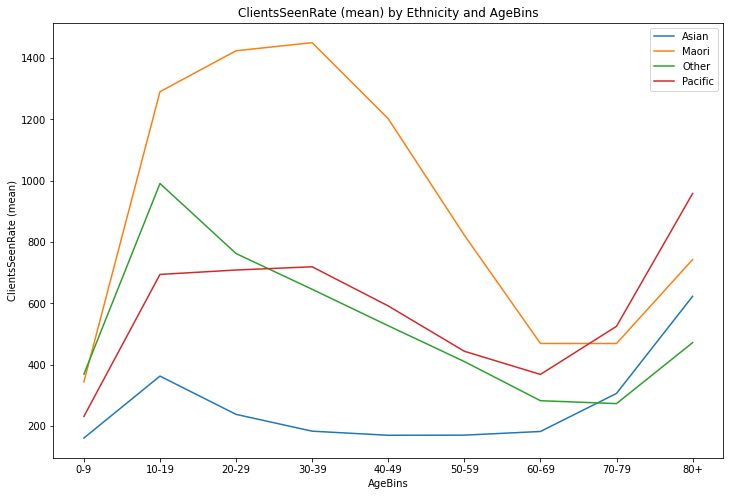

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Create a Spark session
spark = SparkSession.builder.appName("RandomForestClassifierModel").getOrCreate()

# Filter out rows where Ethnicity is 'Total'
filtered_df = df.filter(col('Ethnicity') != 'Total')

# Group by 'Ethnicity' and 'AgeBins', calculate mean of 'ClientsSeenRate'
grouped_data = filtered_df.groupBy('Ethnicity', 'AgeBins').agg({'ClientsSeenRate': 'mean'})

# Convert the result to Pandas for easy plotting
plot_data = grouped_data.toPandas()

# Sort by AgeBins
plot_data = plot_data.sort_values(by='AgeBins')

# Plotting
plt.figure(figsize=(12, 8))

# Plot ClientsSeenRate (mean) for each Ethnicity
for ethnicity, group in plot_data.groupby('Ethnicity'):
    plt.plot(group['AgeBins'], group['avg(ClientsSeenRate)'], label=ethnicity)

# Title and labels
plt.title('ClientsSeenRate (mean) by Ethnicity and AgeBins')
plt.xlabel('AgeBins')
plt.ylabel('ClientsSeenRate (mean)')

# Show legend
plt.legend()

# Show the plot
plt.show()



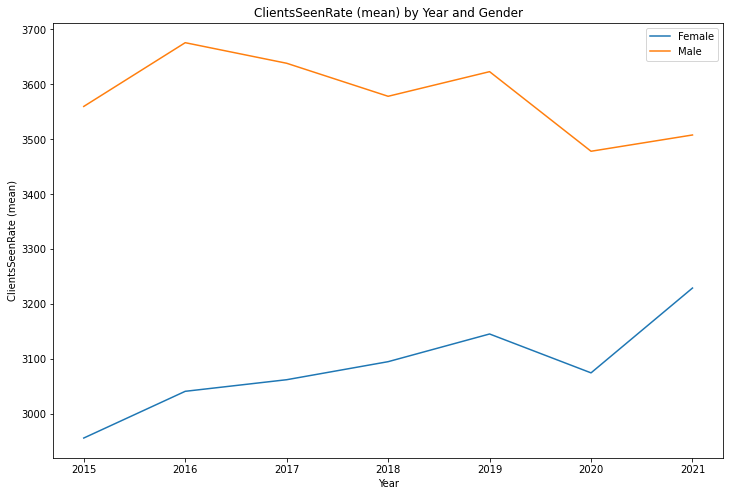

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Create a Spark session
spark = SparkSession.builder.appName("RandomForestClassifierModel").getOrCreate()

# Filter out rows where Ethnicity is 'Total' and Gender is 'Total', and Year is between 2015 and 2021
filtered_df = df.filter((col('Ethnicity') != 'Total') & 
                        (col('Gender') != 'Total') & 
                        (col('Year').between(2015, 2021)))

# Group by 'Year', 'Gender', and calculate mean of 'ClientsSeenRate'
grouped_data = filtered_df.groupBy('Year', 'Gender').agg({'ClientsSeenRate': 'mean'})

# Convert the result to Pandas for easy plotting
plot_data = grouped_data.toPandas()

# Sort by Year and Gender
plot_data = plot_data.sort_values(by=['Year', 'Gender'])

# Plotting
plt.figure(figsize=(12, 8))

# Plot ClientsSeenRate (mean) for each Gender
for gender, group in plot_data.groupby('Gender'):
    plt.plot(group['Year'], group['avg(ClientsSeenRate)'], label=gender)

# Title and labels
plt.title('ClientsSeenRate (mean) by Year and Gender')
plt.xlabel('Year')
plt.ylabel('ClientsSeenRate (mean)')

# Show legend
plt.legend()

# Show the plot
plt.show()



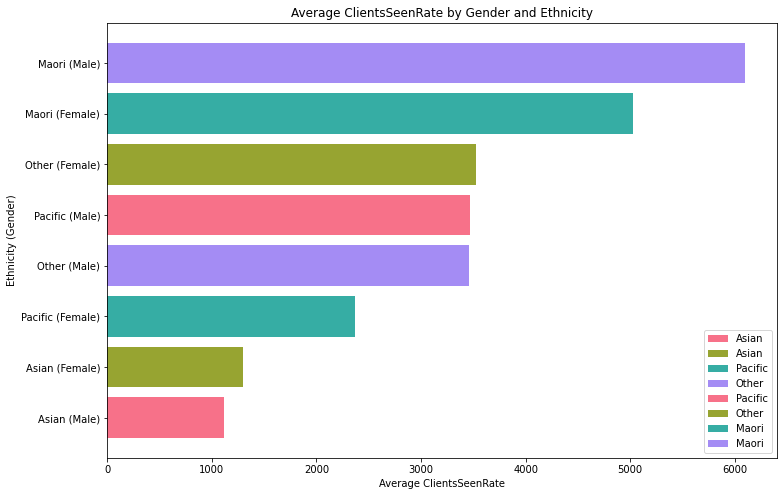

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import seaborn as sns  # Import seaborn for color palettes

# Create a Spark session
spark = SparkSession.builder.appName("RandomForestClassifierModel").getOrCreate()


# Filter out rows where Ethnicity is 'Total' and Gender is 'Total'
filtered_df = df.filter((col('Ethnicity') != 'Total') & (col('Gender').isin('Male', 'Female')))

# Group by 'Gender', 'Ethnicity', and calculate mean of 'ClientsSeenRate'
grouped_data = filtered_df.groupBy('Gender', 'Ethnicity').agg({'ClientsSeenRate': 'mean'})

# Convert the result to Pandas for easy plotting
plot_data = grouped_data.toPandas()

# Sort by average ClientsSeenRate
plot_data = plot_data.sort_values(by='avg(ClientsSeenRate)')

# Use seaborn color palette for better visual appeal
colors = sns.color_palette('husl', n_colors=len(plot_data['Ethnicity'].unique()))

# Plotting
plt.figure(figsize=(12, 8))

# Create horizontal bar chart with different colors for each ethnicity
bars = plt.barh(range(len(plot_data)), plot_data['avg(ClientsSeenRate)'], color=colors)
plt.yticks(range(len(plot_data)), [f"{eth} ({gen})" for eth, gen in zip(plot_data['Ethnicity'], plot_data['Gender'])])

# Title and labels
plt.title('Average ClientsSeenRate by Gender and Ethnicity')
plt.xlabel('Average ClientsSeenRate')
plt.ylabel('Ethnicity (Gender)')

# Add legend with color information
plt.legend(bars, plot_data['Ethnicity'])

# Show the plot
plt.show()



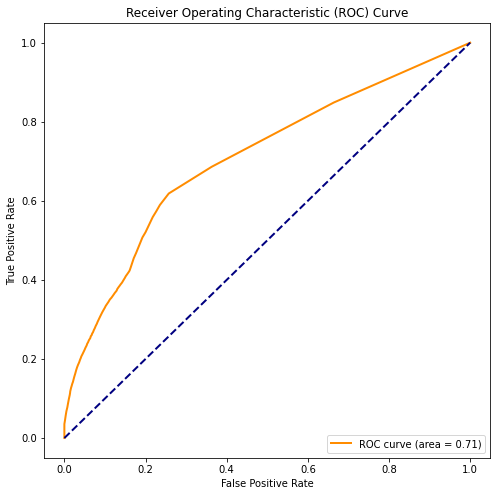

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline

# Create a Spark session
spark = SparkSession.builder.appName("RandomForestClassifierCV").getOrCreate()

# Load data
csv_file_path = 'Merged-data.csv'
df = spark.read.format("csv").option("header", "true").load(csv_file_path)

# Using Binary target variable (1 or 0)
# If 'ClientsSeenRate' > threshold, set 'Target' to 1; otherwise, set it to 0.
threshold = 200
df = df.withColumn('Target', (df['ClientsSeenRate'] > threshold).cast("integer"))

# Select the features and target variable
selected_cols = ['Gender', 'AgeGroup', 'Ethnicity']
feature_cols = ['encoded_' + col for col in selected_cols]

# Encode categorical variables (Gender, AgeGroup, Ethnicity)
indexers = [StringIndexer(inputCol=col, outputCol='encoded_' + col).fit(df) for col in selected_cols]
pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

# Split the data into training and testing sets
(train_data, test_data) = df.randomSplit([0.7, 0.3], seed=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="Target")

# Create a parameter grid for cross-validation
param_grid = ParamGridBuilder() \
    .addGrid(rf_classifier.numTrees, [10, 20, 30]) \
    .addGrid(rf_classifier.maxDepth, [5, 10, 15]) \
    .build()

# Set up the cross-validator
cross_validator = CrossValidator(estimator=rf_classifier,
                                 estimatorParamMaps=param_grid,
                                 evaluator=BinaryClassificationEvaluator(labelCol="Target", rawPredictionCol="rawPrediction", metricName="areaUnderROC"),
                                 numFolds=4,  # We can adjust the number of folds as needed
                                 seed=42)

# Run cross-validation and choose the best set of parameters
cv_model = cross_validator.fit(train_data)

# Make predictions on the test set using the best model
cv_predictions = cv_model.transform(test_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="Target", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
cv_accuracy = evaluator.evaluate(cv_predictions)

# Plot the ROC curve
def plot_roc_curve(predictions, label_col='Target', raw_prediction_col='rawPrediction'):
    y_true = [row[label_col] for row in predictions.select(label_col).collect()]
    y_scores = [row[raw_prediction_col][1] for row in predictions.select(raw_prediction_col).collect()]

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Plot the ROC curve for the cross-validated model
plot_roc_curve(cv_predictions)



In [16]:
from pyspark.sql import SparkSession

evaluator = BinaryClassificationEvaluator(labelCol="Target", rawPredictionCol="rawPrediction", metricName="areaUnderPR")
auc_pr = evaluator.evaluate(cv_predictions)
print("AUC-PR:", auc_pr)

AUC-PR: 0.4285876294737386


In [17]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="Target", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(cv_predictions)
print("F1 Score:", f1_score)


F1 Score: 0.7548203248573726


In [18]:
true_positives = cv_predictions.filter("prediction = 1 AND Target = 1").count()
false_positives = cv_predictions.filter("prediction = 1 AND Target = 0").count()
false_negatives = cv_predictions.filter("prediction = 0 AND Target = 1").count()

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)

print("Precision:", precision)
print("Recall:", recall)


Precision: 0.6691769768692846
Recall: 0.10918985341876591


# OBJ 2 - K-means Clustering

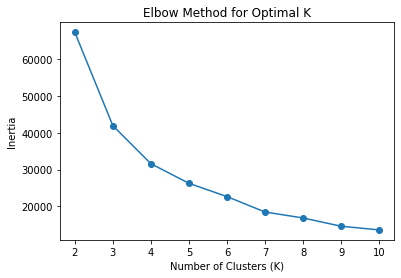

+---------+--------------------+-------+
|TeamIndex|     scaled_features|cluster|
+---------+--------------------+-------+
|      5.0|[-0.2801231818286...|      0|
|      0.0|[1.12158384180993...|      0|
|      1.0|[-0.2531116218410...|      0|
|      7.0|[-0.2849466746835...|      0|
|      2.0|[-0.2068060904339...|      0|
|     10.0|[-0.2839819761125...|      0|
|      8.0|[-0.2849466746835...|      0|
|      6.0|[-0.2733702918317...|      0|
|      5.0|[-0.2675821004058...|      0|
|      0.0|[5.82738347106589...|      1|
|      1.0|[-0.2193471718566...|      0|
|      7.0|[-0.2637233061219...|      0|
|      4.0|[-0.2801231818286...|      0|
|      2.0|[0.10286215085169...|      0|
|      8.0|[-0.2810878803996...|      0|
|      6.0|[-0.0621013047864...|      0|
|      5.0|[-0.1170891233324...|      0|
|      0.0|[9.90516433061181...|      1|
|      1.0|[2.21651671987584...|      2|
|      3.0|[-0.0881481662029...|      0|
+---------+--------------------+-------+
only showing top

In [17]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml import Pipeline

# Initialize Spark session
spark = SparkSession.builder.appName("ClusterAnalysis").getOrCreate()

# Load data from CSV
csv_file_path = 'Merged-data.csv'
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

# Filter out rows where 'TeamType' is not 'Total'
df = df.filter(col('Team') != 'Total')

# Encode categorical variables
indexer = StringIndexer(inputCol='Team', outputCol='TeamIndex')
df = indexer.fit(df).transform(df)

# Standardize numerical features
numerical_cols = ['ClientsSeen', 'ClientsSeenFaceToFace', 'Contacts']
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
assembler = VectorAssembler(inputCols=numerical_cols, outputCol='features')
pipeline = Pipeline(stages=[assembler, scaler])
model = pipeline.fit(df)
df = model.transform(df)

# Select relevant features for clustering
selected_features = ['TeamIndex', 'scaled_features']
df = df.select(selected_features)

# Determine the optimal number of clusters using the elbow method
k_values = range(2, 11)
inertia_values = []

for k in k_values:
    kmeans = KMeans(featuresCol='scaled_features', k=k, seed=42)
    model = kmeans.fit(df)
    inertia_values.append(model.summary.trainingCost)

# Plot the elbow method to choose the optimal K
import matplotlib.pyplot as plt
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

# Choose the optimal number of clusters
optimal_k = 3

# Fit the KMeans model with the chosen K
kmeans = KMeans(featuresCol='scaled_features', k=optimal_k, seed=42, predictionCol='cluster')

# Create a new instance of the model and fit it
model = kmeans.fit(df)

# Add the 'cluster' column to the original DataFrame
clustered_df = model.transform(df)

# Display the results
clustered_df.select('TeamIndex', 'scaled_features', 'cluster').show()

# Display profile of specific columns
clustered_df.select('scaled_features', 'cluster').describe().show()



In [22]:
# Profile the clusters
cluster_profiles = clustered_df.groupBy('cluster').mean()
cluster_profiles.show()

+-------+--------------------+------------+
|cluster|      avg(TeamIndex)|avg(cluster)|
+-------+--------------------+------------+
|      1|0.029900332225913623|         1.0|
|      2|  0.3950381679389313|         2.0|
|      0|   4.702726252115484|         0.0|
+-------+--------------------+------------+



In [23]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.linalg import DenseVector
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType

# Assuming 'scaled_features' is a DenseVector column
extract_values_udf = udf(lambda v: float(v[0]), DoubleType())
clustered_df = clustered_df.withColumn('scaled_features_value', extract_values_udf(col('scaled_features')))

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = clustered_df.toPandas()

# Group by 'cluster' and calculate various statistics for each numerical column
cluster_profiles = pandas_df.groupby('cluster').agg(
    {'scaled_features_value': ['mean', 'std', 'count', 'min', 'max']}
)

# Flatten the multi-level column index
cluster_profiles.columns = ['_'.join(col).strip() for col in cluster_profiles.columns.values]

# Show the cluster profiles
print(cluster_profiles)


         scaled_features_value_mean  scaled_features_value_std  \
cluster                                                          
0                         -0.172500                   0.272822   
1                          6.919302                   2.719519   
2                          2.924230                   1.539989   

         scaled_features_value_count  scaled_features_value_min  \
cluster                                                           
0                              59679                  -0.284947   
1                                602                   2.949688   
2                               2096                   0.611258   

         scaled_features_value_max  
cluster                             
0                         3.026864  
1                        18.546934  
2                        11.566375  


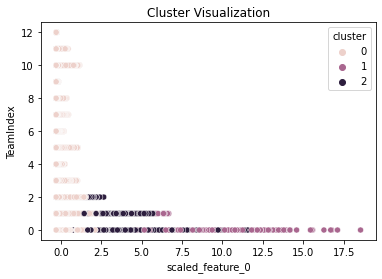

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the PySpark DataFrame to a Pandas DataFrame for easier plotting
pandas_df = clustered_df.toPandas()

# Extract individual components from the DenseVector
for i in range(len(pandas_df['scaled_features'][0])):
    pandas_df[f'scaled_feature_{i}'] = pandas_df['scaled_features'].apply(lambda x: x[i])

# Scatter plot to visualize clusters
sns.scatterplot(x='scaled_feature_0', y='TeamIndex', hue='cluster', data=pandas_df)
plt.title("Cluster Visualization")
plt.show()

In [23]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml import Pipeline

# Initialize Spark session
spark = SparkSession.builder.appName("ClusterAnalysis").getOrCreate()

# Load data from CSV
csv_file_path = 'Merged-data.csv'
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

# Filter out rows where 'TeamType' is not 'Total'
df = df.filter(col('Team') != 'Total')

# Encode categorical variables
indexer = StringIndexer(inputCol='Team', outputCol='TeamIndex')
df = indexer.fit(df).transform(df)

# Select relevant features for clustering
selected_columns = ['Team', 'ClientsSeen', 'ClientsSeenFaceToFace', 'Contacts']
df_for_clustering = df.select(selected_columns)

# Standardize numerical features
numerical_cols = ['ClientsSeen', 'ClientsSeenFaceToFace', 'Contacts']
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
assembler = VectorAssembler(inputCols=numerical_cols, outputCol='features')
pipeline = Pipeline(stages=[assembler, scaler])
model = pipeline.fit(df_for_clustering)
df_for_clustering = model.transform(df_for_clustering)

# Save the necessary columns before feature selection
selected_features = ['TeamIndex', 'scaled_features']

# Determine the optimal number of clusters using the elbow method
k_values = range(2, 11)
inertia_values = []

for k in k_values:
    kmeans = KMeans(featuresCol='scaled_features', k=k, seed=42)
    model = kmeans.fit(df_for_clustering)
    inertia_values.append(model.summary.trainingCost)

# Choose the optimal number of clusters
optimal_k = 3

# Fit the KMeans model with the chosen K
kmeans = KMeans(featuresCol='scaled_features', k=optimal_k, seed=42, predictionCol='cluster')

# Create a new instance of the model and fit it
model = kmeans.fit(df_for_clustering)

# Add the 'cluster' column to the original DataFrame
clustered_df = model.transform(df_for_clustering)

# Display the results
clustered_df.select('Team', 'ClientsSeen', 'ClientsSeenFaceToFace', 'Contacts', 'cluster').show()

# Display profile of specific columns
clustered_df.select('ClientsSeen', 'ClientsSeenFaceToFace', 'Contacts', 'cluster').describe().show()


+------------------+-----------+---------------------+--------+-------+
|              Team|ClientsSeen|ClientsSeenFaceToFace|Contacts|cluster|
+------------------+-----------+---------------------+--------+-------+
|         Inpatient|          6|                    6|       0|      0|
|              Comm|       1459|                 1082|   14896|      0|
|               A&D|         34|                   32|      63|      0|
|       Residential|          1|                    1|       0|      0|
|         Specialty|         82|                   59|     745|      0|
|       Maternal MH|          2|                    0|       3|      0|
|Early Intervention|          1|                    1|       1|      0|
|      Coordination|         13|                   11|      93|      0|
|         Inpatient|         19|                   19|       0|      0|
|              Comm|       6337|                 5295|   84483|      1|
|               A&D|         69|                   62|     331| 

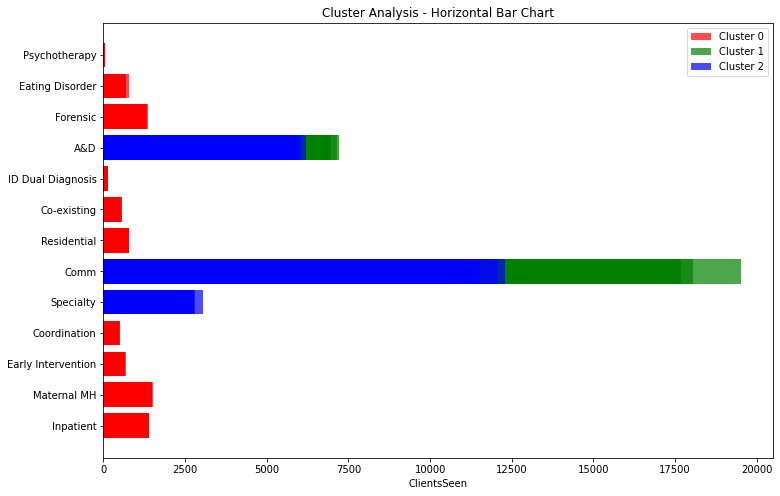

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame for plotting
pandas_df = clustered_df.select('Team', 'ClientsSeen', 'cluster').toPandas()

# Sort the DataFrame by cluster for better visualization
pandas_df = pandas_df.sort_values(by='cluster')

# Plotting a horizontal bar chart
plt.figure(figsize=(12, 8))

colors = ['red', 'green', 'blue']  # Choose colors for each cluster
for cluster_id in range(optimal_k):
    cluster_data = pandas_df[pandas_df['cluster'] == cluster_id]
    plt.barh(cluster_data['Team'], cluster_data['ClientsSeen'], label=f'Cluster {cluster_id}', color=colors[cluster_id], alpha=0.7)

plt.xlabel('ClientsSeen')
plt.title('Cluster Analysis - Horizontal Bar Chart')
plt.legend()
plt.show()



In [35]:
import pandas as pd

# Get a DataFrame with unique teams for each cluster
unique_teams_by_cluster = pandas_df.groupby('cluster')['Team'].unique().reset_index()

# Pivot the table
pivoted_table = pd.DataFrame(unique_teams_by_cluster['Team'].tolist(), index=unique_teams_by_cluster['cluster']).T

# Display the pivoted table
print(pivoted_table)


cluster                   0     1          2
0                 Inpatient  Comm       Comm
1               Maternal MH   A&D        A&D
2        Early Intervention  None  Specialty
3              Coordination  None       None
4                 Specialty  None       None
5                      Comm  None       None
6               Residential  None       None
7               Co-existing  None       None
8         ID Dual Diagnosis  None       None
9                       A&D  None       None
10                 Forensic  None       None
11          Eating Disorder  None       None
12            Psychotherapy  None       None


In [36]:
import pandas as pd

# Get a DataFrame with unique teams and ClientsSeen for each cluster
unique_teams_clients_by_cluster = pandas_df.groupby(['cluster', 'Team'])['ClientsSeen'].max().unstack()

# Display the DataFrame
print(unique_teams_clients_by_cluster)


Team        A&D  Co-existing     Comm  Coordination  Early Intervention  \
cluster                                                                   
0        3173.0        560.0   3434.0         504.0               680.0   
1        7224.0          NaN  19522.0           NaN                 NaN   
2        6202.0          NaN  12286.0           NaN                 NaN   

Team     Eating Disorder  Forensic  ID Dual Diagnosis  Inpatient  Maternal MH  \
cluster                                                                         
0                  769.0    1367.0              146.0     1384.0       1503.0   
1                    NaN       NaN                NaN        NaN          NaN   
2                    NaN       NaN                NaN        NaN          NaN   

Team     Psychotherapy  Residential  Specialty  
cluster                                         
0                 44.0        778.0     1872.0  
1                  NaN          NaN        NaN  
2                  NaN

In [24]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(featuresCol='scaled_features', predictionCol='cluster', metricName='silhouette')

# Calculate Silhouette score
silhouette_score = evaluator.evaluate(clustered_df)
print(f"Silhouette Score: {silhouette_score}")

Silhouette Score: 0.9583707296274857


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.evaluation import ClusteringEvaluator

# Initialize Spark session
spark = SparkSession.builder.appName("ClusterAnalysis").getOrCreate()

# Load data from CSV
csv_file_path = 'Merged-data.csv'
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

# Filter out rows where 'TeamType' is not 'Total'
df = df.filter(col('Team') != 'Total')

# Encode categorical variables
indexer = StringIndexer(inputCol='Team', outputCol='TeamIndex')
df = indexer.fit(df).transform(df)

# Standardize numerical features
numerical_cols = ['ClientsSeen', 'ClientsSeenFaceToFace', 'Contacts']
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
assembler = VectorAssembler(inputCols=numerical_cols, outputCol='features')
pipeline = Pipeline(stages=[assembler, scaler])
model = pipeline.fit(df)
df = model.transform(df)

# Select relevant features for clustering
selected_features = ['TeamIndex', 'scaled_features']
df = df.select(selected_features)

# Split the data into training and testing sets (70/30 split)
train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)

# Choose the optimal number of clusters
optimal_k = 3

# Fit the KMeans model with the chosen K on the training set
kmeans = KMeans(featuresCol='scaled_features', k=optimal_k, seed=42, predictionCol='cluster')
model = kmeans.fit(train_df)

# Add the 'cluster' column to the original DataFrame
clustered_train_df = model.transform(train_df)
clustered_test_df = model.transform(test_df)

# Display the results for the testing set
print("Results on Testing Set:")
clustered_test_df.select('TeamIndex', 'scaled_features', 'cluster').show()

# Evaluate the model on the testing set using ClusteringEvaluator
evaluator = ClusteringEvaluator(featuresCol='scaled_features', predictionCol='cluster')
silhouette = evaluator.evaluate(clustered_test_df)
print(f"Silhouette Score on Testing Set: {silhouette}")


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/08 04:55:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Results on Testing Set:
+---------+--------------------+-------+
|TeamIndex|     scaled_features|cluster|
+---------+--------------------+-------+
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
|      0.0|[-0.2849466746835...|      0|
+---------+--------------------+-

Silhouette Score on Testing Set: 0.9597716632747232


In [3]:
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

# Selecting the features for Davies-Bouldin Index calculation
features_col = 'scaled_features'
prediction_col = 'cluster'
selected_features = ['TeamIndex', features_col, prediction_col]
selected_df = clustered_test_df.select(selected_features)

# Collecting the predictions and features into a list
predictions_and_features = selected_df.collect()

# Extracting the features and predictions
features = [np.array(row[features_col].toArray()) for row in predictions_and_features]
predictions = [row[prediction_col] for row in predictions_and_features]

# Calculating the Davies-Bouldin Index manually
num_clusters = optimal_k
cluster_centroids = [np.array(model.clusterCenters()[i]) for i in range(num_clusters)]

def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

def calculate_davies_bouldin_index():
    cluster_distances = []
    for i in range(num_clusters):
        cluster_i_indices = [index for index, pred in enumerate(predictions) if pred == i]
        centroid_i = cluster_centroids[i]

        intra_cluster_distances = []
        for index in cluster_i_indices:
            feature_vector = features[index]
            intra_cluster_distances.append(euclidean_distance(centroid_i, feature_vector))

        average_intra_cluster_distance = np.mean(intra_cluster_distances)
        inter_cluster_distances = []

        for j in range(num_clusters):
            if j != i:
                centroid_j = cluster_centroids[j]
                inter_cluster_distances.append(euclidean_distance(centroid_i, centroid_j))

        average_inter_cluster_distance = np.mean(inter_cluster_distances)
        cluster_distances.append(average_intra_cluster_distance / average_inter_cluster_distance)

    davies_bouldin_index = np.mean(cluster_distances)
    return davies_bouldin_index

# Calculate Davies-Bouldin Index
davies_bouldin_index = calculate_davies_bouldin_index()
print(f"Davies-Bouldin Index on Testing Set: {davies_bouldin_index}")


Davies-Bouldin Index on Testing Set: 0.26866610332469826


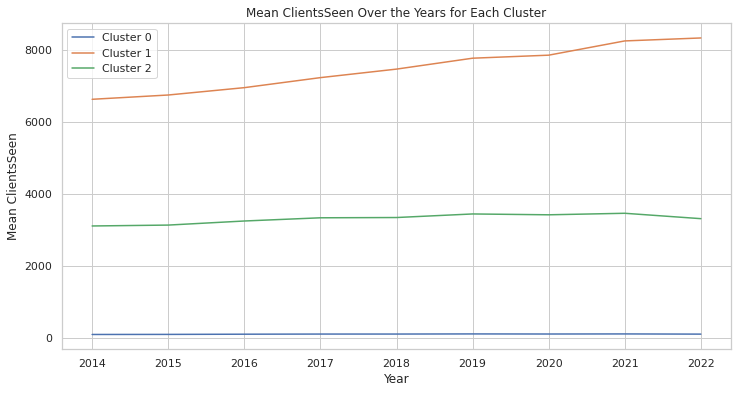

In [39]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml import Pipeline

# Filter columns
filtered_df = clustered_df.select('ClientsSeen', 'Year', 'cluster')

# Aggregate data
aggregated_df = filtered_df.groupBy('Year', 'cluster').agg({'ClientsSeen': 'mean'})

# Sort by 'Year'
aggregated_df = aggregated_df.orderBy('Year')

# Convert to Pandas DataFrame
pandas_df = aggregated_df.toPandas()

# Plotting with Matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Create a line chart for each cluster
for cluster in pandas_df['cluster'].unique():
    cluster_data = pandas_df[pandas_df['cluster'] == cluster]
    plt.plot(cluster_data['Year'], cluster_data['avg(ClientsSeen)'], label=f'Cluster {cluster}')

plt.title('Mean ClientsSeen Over the Years for Each Cluster')
plt.xlabel('Year')
plt.ylabel('Mean ClientsSeen')
plt.legend()
plt.show()


In [46]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.evaluation import ClusteringEvaluator

# Initialize Spark session
spark = SparkSession.builder.appName("ClusterAnalysis").getOrCreate()

# Load data from CSV
csv_file_path = 'Merged-data.csv'
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

# Filter out rows where 'TeamType' is not 'Total'
df = df.filter(col('Team') != 'Total')

# Encode categorical variables
indexer = StringIndexer(inputCol='Team', outputCol='TeamIndex')
df = indexer.fit(df).transform(df)

# Standardize numerical features
numerical_cols = ['ClientsSeen', 'ClientsSeenFaceToFace', 'Contacts']
assembler = VectorAssembler(inputCols=numerical_cols, outputCol='features')
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
pipeline = Pipeline(stages=[assembler, scaler])
model = pipeline.fit(df)
df_for_clustering = model.transform(df)

# Select relevant features for clustering
selected_features = ['TeamIndex', 'scaled_features', 'Ethnicity', 'OrgType', 'Team']
df_for_clustering = df_for_clustering.select(selected_features)

# Choose the optimal number of clusters
optimal_k = 3

# Fit the KMeans model with the chosen K on the training set
kmeans = KMeans(featuresCol='scaled_features', k=optimal_k, seed=42, predictionCol='cluster')
model = kmeans.fit(df_for_clustering)

# Make predictions on the entire DataFrame
predictions = model.transform(df_for_clustering)

# Evaluate clustering performance using Silhouette Score
evaluator = ClusteringEvaluator(featuresCol='scaled_features', predictionCol='cluster', metricName='silhouette')
silhouette_score = evaluator.evaluate(predictions)
print(f'Silhouette Score: {silhouette_score}')

# Display the clustering results along with 'Ethnicity', 'OrgType', and 'Team'
predictions.select('Ethnicity', 'OrgType', 'Team', 'cluster').show()






Silhouette Score: 0.9583707296274857
+---------+-------+------------------+-------+
|Ethnicity|OrgType|              Team|cluster|
+---------+-------+------------------+-------+
|    Total|  Total|         Inpatient|      0|
|    Total|  Total|              Comm|      0|
|    Total|  Total|               A&D|      0|
|    Total|  Total|       Residential|      0|
|    Total|  Total|         Specialty|      0|
|    Total|  Total|       Maternal MH|      0|
|    Total|  Total|Early Intervention|      0|
|    Total|  Total|      Coordination|      0|
|    Total|  Total|         Inpatient|      0|
|    Total|  Total|              Comm|      1|
|    Total|  Total|               A&D|      0|
|    Total|  Total|       Residential|      0|
|    Total|  Total|       Co-existing|      0|
|    Total|  Total|         Specialty|      0|
|    Total|  Total|Early Intervention|      0|
|    Total|  Total|      Coordination|      0|
|    Total|  Total|         Inpatient|      0|
|    Total|  Total|    

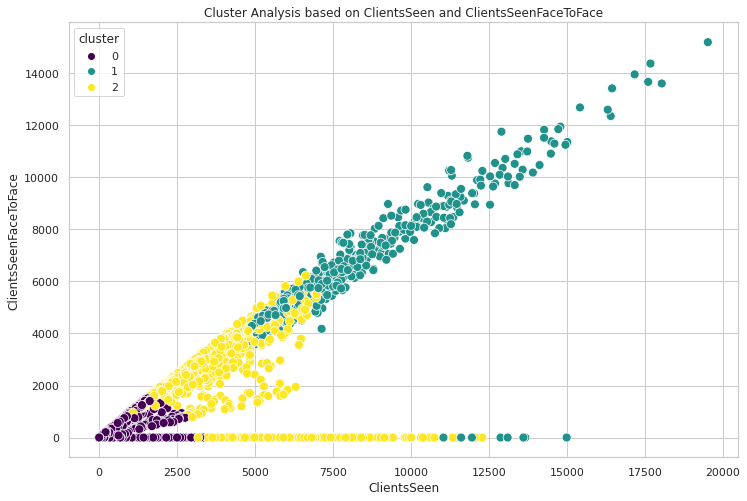

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to Pandas DataFrame for visualization
pandas_df = clustered_df.toPandas()

# Scatter plot of ClientsSeen and ClientsSeenFaceToFace, color-coded by cluster
plt.figure(figsize=(12, 8))
sns.scatterplot(x='ClientsSeen', y='ClientsSeenFaceToFace', hue='cluster', data=pandas_df, palette='viridis', s=80)
plt.title('Cluster Analysis based on ClientsSeen and ClientsSeenFaceToFace')
plt.xlabel('ClientsSeen')
plt.ylabel('ClientsSeenFaceToFace')
plt.show()


In [54]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.evaluation import ClusteringEvaluator

# Initialize Spark session
spark = SparkSession.builder.appName("ClusterAnalysis").getOrCreate()

# Load data from CSV
csv_file_path = 'Merged-data.csv'
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

# Filter out rows where 'TeamType' is not 'Total'
df = df.filter(col('Team') != 'Total')

# Encode categorical variables
indexer = StringIndexer(inputCol='Team', outputCol='TeamIndex')
df = indexer.fit(df).transform(df)

# Standardize numerical features
numerical_cols = ['ClientsSeen', 'ClientsSeenFaceToFace', 'Contacts']
assembler = VectorAssembler(inputCols=numerical_cols, outputCol='features')
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
pipeline = Pipeline(stages=[assembler, scaler])
model = pipeline.fit(df)
df_for_clustering = model.transform(df)

# Select relevant features for clustering
selected_features = ['TeamIndex', 'scaled_features', 'Ethnicity', 'OrgType', 'Team']
df_for_clustering = df_for_clustering.select(selected_features)

# Choose the optimal number of clusters
optimal_k = 3

# Fit the KMeans model with the chosen K on the training set
kmeans = KMeans(featuresCol='scaled_features', k=optimal_k, seed=42, predictionCol='cluster')
model = kmeans.fit(df_for_clustering)

# Make predictions on the entire DataFrame
predictions = model.transform(df_for_clustering)

# Display the clustering results along with 'Ethnicity', 'OrgType', and 'Team'
clustered_teams = predictions.select('Ethnicity', 'OrgType', 'Team', 'cluster')

# Exclude rows where 'Ethnicity' is 'Total'
clustered_teams = clustered_teams.filter(col('Ethnicity') != 'Total')

# Show the distribution of teams across Ethnicity and cluster
clustered_teams.groupBy('cluster', 'Ethnicity').pivot('cluster').count().show()





+-------+---------+----+----+----+
|cluster|Ethnicity|   0|   1|   2|
+-------+---------+----+----+----+
|      1|    Other|null|  91|null|
|      0|    Maori|1497|null|null|
|      0|    Asian|1390|null|null|
|      2|    Other|null|null| 142|
|      0|    Other|1564|null|null|
|      0|  Pacific|1423|null|null|
|      2|    Maori|null|null| 151|
+-------+---------+----+----+----+



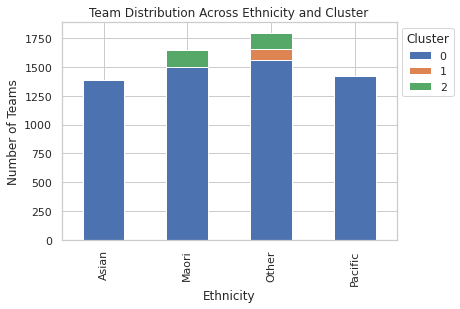

In [56]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder.appName("ClusterAnalysis").getOrCreate()

# Load data from CSV
csv_file_path = 'Merged-data.csv'
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

# Filter out rows where 'TeamType' is not 'Total'
df = df.filter(col('Team') != 'Total')

# Encode categorical variables
indexer = StringIndexer(inputCol='Team', outputCol='TeamIndex')
df = indexer.fit(df).transform(df)

# Standardize numerical features
numerical_cols = ['ClientsSeen', 'ClientsSeenFaceToFace', 'Contacts']
assembler = VectorAssembler(inputCols=numerical_cols, outputCol='features')
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
pipeline = Pipeline(stages=[assembler, scaler])
model = pipeline.fit(df)
df_for_clustering = model.transform(df)

# Select relevant features for clustering
selected_features = ['TeamIndex', 'scaled_features', 'Ethnicity', 'OrgType', 'Team']
df_for_clustering = df_for_clustering.select(selected_features)

# Choose the optimal number of clusters
optimal_k = 3

# Fit the KMeans model with the chosen K on the training set
kmeans = KMeans(featuresCol='scaled_features', k=optimal_k, seed=42, predictionCol='cluster')
model = kmeans.fit(df_for_clustering)

# Make predictions on the entire DataFrame
predictions = model.transform(df_for_clustering)

# Display the clustering results along with 'Ethnicity', 'OrgType', and 'Team'
clustered_teams = predictions.select('Ethnicity', 'OrgType', 'Team', 'cluster')

# Exclude rows where 'Ethnicity' is 'Total'
clustered_teams = clustered_teams.filter(col('Ethnicity') != 'Total')

# Count the number of teams for each combination of cluster and ethnicity
team_counts = clustered_teams.groupBy('cluster', 'Ethnicity').count().toPandas()

# Pivot the DataFrame for plotting
pivot_df = team_counts.pivot(index='Ethnicity', columns='cluster', values='count')

# Plotting
pivot_df.plot(kind='bar', stacked=True)
plt.title('Team Distribution Across Ethnicity and Cluster')
plt.xlabel('Ethnicity')
plt.ylabel('Number of Teams')
plt.legend(title='Cluster', bbox_to_anchor=(1, 1))
plt.show()


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/12 00:56:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/12 00:56:27 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


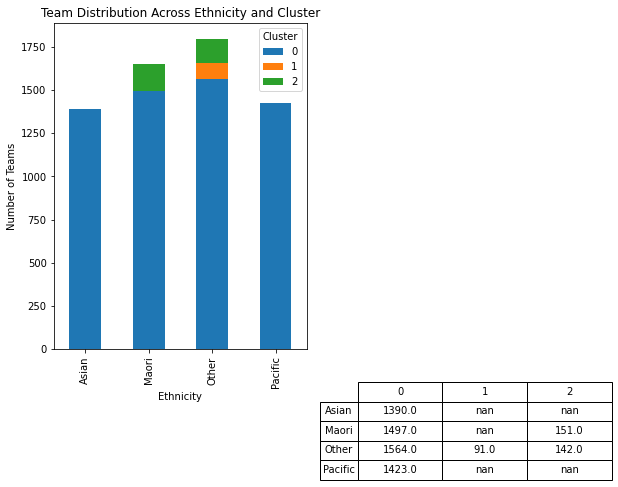

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder.appName("ClusterAnalysis").getOrCreate()

# Load data from CSV
csv_file_path = 'Merged-data.csv'
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

# Filter out rows where 'TeamType' is not 'Total'
df = df.filter(col('Team') != 'Total')

# Encode categorical variables
indexer = StringIndexer(inputCol='Team', outputCol='TeamIndex')
df = indexer.fit(df).transform(df)

# Standardize numerical features
numerical_cols = ['ClientsSeen', 'ClientsSeenFaceToFace', 'Contacts']
assembler = VectorAssembler(inputCols=numerical_cols, outputCol='features')
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
pipeline = Pipeline(stages=[assembler, scaler])
model = pipeline.fit(df)
df_for_clustering = model.transform(df)

# Select relevant features for clustering
selected_features = ['TeamIndex', 'scaled_features', 'Ethnicity', 'OrgType', 'Team']
df_for_clustering = df_for_clustering.select(selected_features)

# Choose the optimal number of clusters
optimal_k = 3

# Fit the KMeans model with the chosen K on the training set
kmeans = KMeans(featuresCol='scaled_features', k=optimal_k, seed=42, predictionCol='cluster')
model = kmeans.fit(df_for_clustering)

# Make predictions on the entire DataFrame
predictions = model.transform(df_for_clustering)

# Display the clustering results along with 'Ethnicity', 'OrgType', and 'Team'
clustered_teams = predictions.select('Ethnicity', 'OrgType', 'Team', 'cluster')

# Exclude rows where 'Ethnicity' is 'Total'
clustered_teams = clustered_teams.filter(col('Ethnicity') != 'Total')

# Count the number of teams for each combination of cluster and ethnicity
team_counts = clustered_teams.groupBy('cluster', 'Ethnicity').count().toPandas()

# Pivot the DataFrame for table display
pivot_df = team_counts.pivot(index='Ethnicity', columns='cluster', values='count')

# Plotting the bar chart and displaying the table
plt.figure(figsize=(10, 6))

# Plotting the bar chart
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
pivot_df.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Team Distribution Across Ethnicity and Cluster')
plt.xlabel('Ethnicity')
plt.ylabel('Number of Teams')
plt.legend(title='Cluster', bbox_to_anchor=(1, 1))

# Displaying the table
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.axis('off')  # Turn off axis for the table
plt.table(cellText=pivot_df.values,
          rowLabels=pivot_df.index,
          colLabels=pivot_df.columns,
          loc='center',
          cellLoc='center',
          rowLoc='center',
          bbox=[0, -0.4, 1, 0.3])  # Adjust bbox as needed

plt.show()


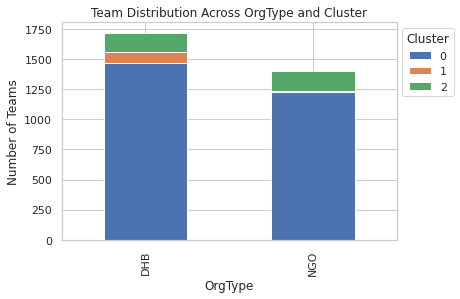

,cluster,OrgType,count
0,0,DHB,1467
1,1,NGO,4
2,2,DHB,157
3,2,NGO,169
4,0,NGO,1229
5,1,DHB,93


In [58]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder.appName("ClusterAnalysis").getOrCreate()

# Load data from CSV
csv_file_path = 'Merged-data.csv'
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

# Filter out rows where 'TeamType' is not 'Total'
df = df.filter(col('Team') != 'Total')

# Encode categorical variables
indexer = StringIndexer(inputCol='Team', outputCol='TeamIndex')
df = indexer.fit(df).transform(df)

# Standardize numerical features
numerical_cols = ['ClientsSeen', 'ClientsSeenFaceToFace', 'Contacts']
assembler = VectorAssembler(inputCols=numerical_cols, outputCol='features')
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
pipeline = Pipeline(stages=[assembler, scaler])
model = pipeline.fit(df)
df_for_clustering = model.transform(df)

# Select relevant features for clustering
selected_features = ['TeamIndex', 'scaled_features', 'OrgType']
df_for_clustering = df_for_clustering.select(selected_features)

# Choose the optimal number of clusters
optimal_k = 3

# Fit the KMeans model with the chosen K on the training set
kmeans = KMeans(featuresCol='scaled_features', k=optimal_k, seed=42, predictionCol='cluster')
model = kmeans.fit(df_for_clustering)

# Make predictions on the entire DataFrame
predictions = model.transform(df_for_clustering)

# Display the clustering results along with 'OrgType'
clustered_org_types = predictions.select('OrgType', 'cluster')

# Exclude rows where 'OrgType' is 'Total'
clustered_org_types = clustered_org_types.filter(col('OrgType') != 'Total')

# Count the number of teams for each combination of cluster and OrgType
org_type_counts = clustered_org_types.groupBy('cluster', 'OrgType').count().toPandas()

# Pivot the DataFrame for plotting
pivot_org_type_df = org_type_counts.pivot(index='OrgType', columns='cluster', values='count')

# Plotting
pivot_org_type_df.plot(kind='bar', stacked=True)
plt.title('Team Distribution Across OrgType and Cluster')
plt.xlabel('OrgType')
plt.ylabel('Number of Teams')
plt.legend(title='Cluster', bbox_to_anchor=(1, 1))
plt.show()

# Display the table
org_type_counts

